In [1]:
import evaluate
import pandas as pd
import numpy as np
import datasets
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from functools import partial

import os
import time
import tracemalloc

from transformers import AutoTokenizer, get_linear_schedule_with_warmup
import torch

import onnx
import onnxruntime
import psutil

from backend.model_utils import preds_to_bio


torch.manual_seed(0)

CACHE_DIR = 'data'

### Данные тесты будут актуальны для всех используемых моделей, поскольку все они имеют схожие архитектуры и размеры.

In [2]:
all_datasets = datasets.load_dataset('tner/tweetner7', cache_dir=CACHE_DIR)
test_dataset = datasets.concatenate_datasets([all_datasets['test_2020'], all_datasets['test_2021']])

In [3]:
save_path = "bert_base_warmup"
model_name = "google-bert/bert-base-cased"

ner_model = torch.load(os.path.join('checkpoints', save_path, 'best_model.pth'), weights_only=False).eval().to(torch.float16)
ner_tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, clean_up_tokenization_spaces=False)
ner_tokenizer.add_tokens(["{{URL}}", "{{USERNAME}}", "{@", "@}"])

batch_size = 8
device = 'cuda'

In [4]:
export_model_path = 'onnx/bert_base.onnx'
opset_version = 14
ner_model.to(device)

batch = test_dataset[0: 0 + batch_size]['tokens']
encoded_batch = ner_tokenizer(batch,
                              return_tensors='pt',
                              max_length=128,
                              truncation=True,
                              add_special_tokens=True,
                              padding='max_length',
                              is_split_into_words=True).to(device)
with torch.no_grad():
    symbolic_names = {0: 'batch_size', 1: 'max_seq_len'}
    torch.onnx.export(ner_model,                                            # model being run
                      args=tuple(encoded_batch.values()),                      # model input (or a tuple for multiple inputs)
                      f=export_model_path,                              # where to save the model (can be a file or file-like object)
                      opset_version=opset_version,                      # the ONNX version to export the model to
                      do_constant_folding=True,                         # whether to execute constant folding for optimization
                      input_names=['input_ids',                         # the model's input names
                                   'attention_mask',
                                   'token_type_ids'],
                      output_names=['logits'],                    # the model's output names
                      dynamic_axes={'input_ids': symbolic_names,        # variable length axes
                                    'attention_mask' : symbolic_names,
                                    'token_type_ids': symbolic_names,
                                    'logits' : symbolic_names})
    print("Model exported at ", export_model_path)

Model exported at  onnx/bert_base.onnx


In [5]:
def profile_torch(model, tokenizer, batch_size, device, padding):
    times = []
    for ind in range(0, len(test_dataset), batch_size):
        batch = test_dataset[ind: ind + batch_size]['tokens']
        start = time.time()
        encoded_batch = tokenizer(batch,
                                      return_tensors='pt',
                                      max_length=128,
                                      truncation=True,
                                      add_special_tokens=True,
                                      padding=padding,
                                      is_split_into_words=True).to(device)
        with torch.no_grad():
            output = model(**encoded_batch).logits.argmax(-1).tolist()
        times.append(time.time() - start)
    
    percentage = int(len(times) * 0.05)
    times = sorted(times)[percentage: -percentage]
    return times

def profile_onnx(model, tokenizer, batch_size, device, padding):
    times = []
    for ind in range(0, len(test_dataset), batch_size):
        batch = test_dataset[ind: ind + batch_size]['tokens']
        start = time.time()
        encoded_batch = tokenizer(batch,
                                      max_length=128,
                                      truncation=True,
                                      add_special_tokens=True,
                                      padding=padding,
                                      is_split_into_words=True)
        outputs = model.run(None, dict(encoded_batch))[0].argmax(-1).tolist()
        times.append(time.time() - start)
    
    percentage = int(len(times) * 0.05)
    times = sorted(times)[percentage: -percentage]
    return times

def get_stats(profile_fn, ner_model, ner_tokenizer, device, padding):
    mean_times = []
    mem_cpu = []
    mem_gpu = []
    for batch_size in batch_sizes:
        torch.cuda.reset_peak_memory_stats()
        tracemalloc.start()
        
        times = profile_fn(ner_model, ner_tokenizer, batch_size, device, padding)
        peak_cpu_memory = tracemalloc.get_traced_memory()[1] / (1024 ** 2)
        peak_gpu_memory = torch.cuda.max_memory_allocated() / (1024 ** 2)
        tracemalloc.stop()
        
        mean_time = sum(times) / len(times)
        mean_times.append(mean_time)
    
        mem_cpu.append(peak_cpu_memory)
        mem_gpu.append(peak_gpu_memory)
        time.sleep(1)
    return mean_times, mem_cpu, mem_gpu

def plot_stats(stats: list, labels: list):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for (mean_times, mem_cpu, mem_gpu) in stats:
        axes[0].plot(batch_sizes, mean_times)
        axes[1].plot(batch_sizes, mem_cpu)
        axes[2].plot(batch_sizes, mem_gpu)
    
    axes[0].title.set_text('Time')
    axes[1].title.set_text('RAM memory')
    axes[2].title.set_text('GPU memory')
    
    axes[0].set_xlabel('Batch size')
    axes[1].set_xlabel('Batch size')
    axes[2].set_xlabel('Batch size')
    
    fig.legend(labels)

In [6]:
batch_sizes = list(range(1, 9))

# GPU inference

### Inference with inputs padded to max_length

### PyTorch

In [7]:
ner_model.to(device)
torch_stats = get_stats(profile_torch, ner_model, ner_tokenizer, device, 'max_length')

### Onnx

In [8]:
sess_options = onnxruntime.SessionOptions()
output_dir = 'onnx'
sess_options.optimized_model_filepath = os.path.join(output_dir, "optimized_model_{}.onnx".format(device))
sess_options.intra_op_num_threads=psutil.cpu_count(logical=True)

session = onnxruntime.InferenceSession(export_model_path, sess_options, providers=["CUDAExecutionProvider", "CPUExecutionProvider"])

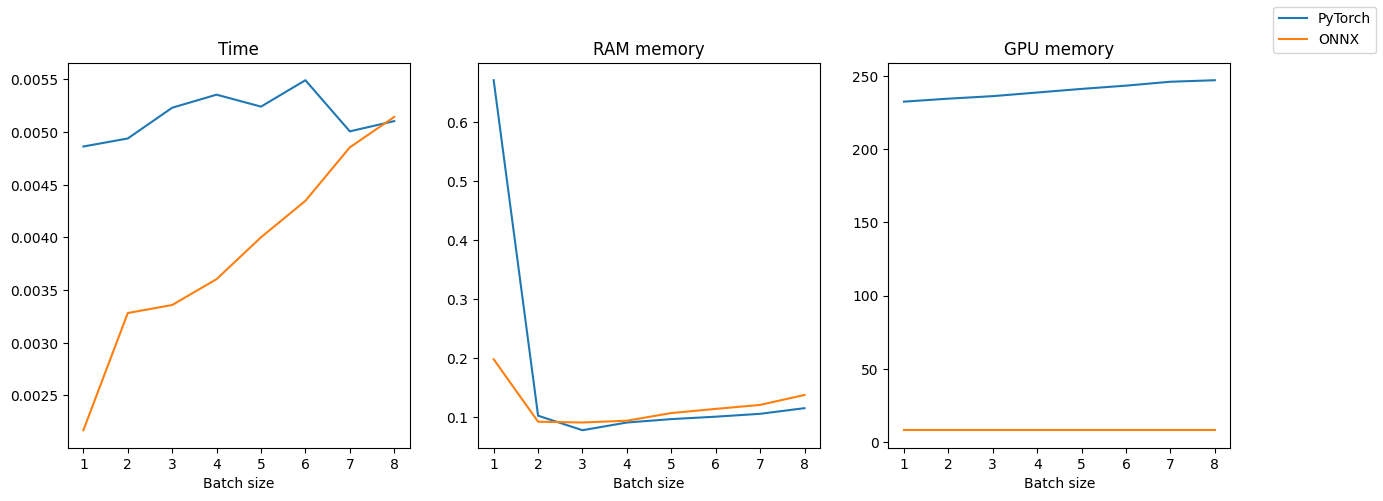

In [9]:
# remove torch model from GPU
del ner_model
torch.cuda.empty_cache()

onnx_stats = get_stats(profile_onnx, session, ner_tokenizer, device, 'max_length')
plot_stats([torch_stats, onnx_stats], ['PyTorch', 'ONNX'])

## Inference with not padded inputs

### PyTorch

In [10]:
ner_model = torch.load(os.path.join('checkpoints', save_path, 'best_model.pth'), weights_only=False).eval().to(torch.float16)
ner_model.to(device)
torch_stats = get_stats(profile_torch, ner_model, ner_tokenizer, device, True)

In [11]:
ner_model.save_pretrained(os.path.join('checkpoints', 'bert_hf'))

### ONNX

In [12]:
del ner_model
torch.cuda.empty_cache()

onnx_stats = get_stats(profile_onnx, session, ner_tokenizer, device, True)

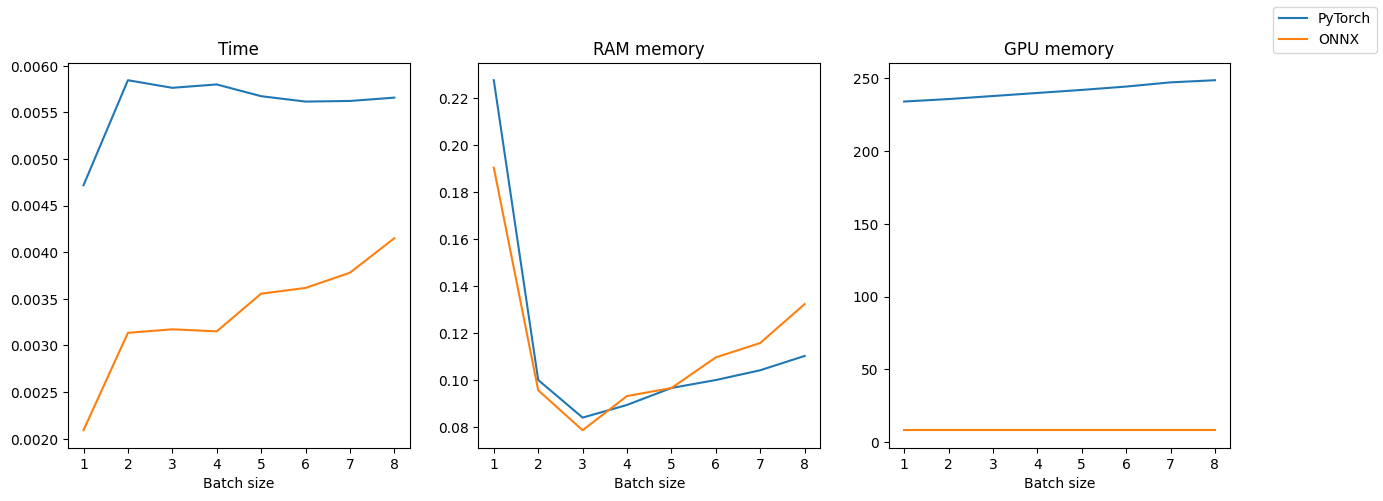

In [13]:
plot_stats([torch_stats, onnx_stats], ['PyTorch', 'ONNX'])

В обоих случаях при инференсе на GPU, модель, сконвертированная в ONNX формат показывает себя быстрее, чем PyTorch.

# Quantization

In [14]:
labels_list = ['corporation', 'creative_work', 'event', 'group', 'location', 'person', 'product']
global_metrics = ['overall_precision', 'overall_recall', 'overall_f1', 'overall_accuracy']

def calculate_metrics(predictions: list[str], labels: list[str]):
    metric = evaluate.load("seqeval")
    predictions_adj = [predictions[i] for i in range(len(predictions)) if len(predictions[i]) == len(labels[i])]
    labels_adj = [labels[i] for i in range(len(labels)) if len(predictions[i]) == len(labels[i])]
    metrics = metric.compute(predictions=list(predictions_adj), references=labels_adj)
    metrics_class = {k: metrics[k] for k in labels_list}
    metrics_global = {k: metrics[k] for k in global_metrics}
    print(pd.DataFrame(metrics_class), '\n')
    print(pd.DataFrame([metrics_global], columns=list(metrics_global.keys()), index=['Value']))
    return metrics_class, metrics_global

In [15]:
from transformers import AutoModelForTokenClassification, GPTQConfig 

calibration_data = list(map(' '.join, all_datasets['train_all']['tokens']))
gptq_config = GPTQConfig(bits=4, dataset=calibration_data, tokenizer=ner_tokenizer, block_name_to_quantize='bert.encoder.layer')

model_8bit = AutoModelForTokenClassification.from_pretrained(
    'checkpoints/bert_hf', 
    quantization_config=gptq_config,
    device_map='cuda',
).eval()

CUDA extension not installed.
CUDA extension not installed.


Quantizing bert.encoder.layer blocks :   0%|          | 0/12 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


In [16]:
def to_bio(row, labels_mapping: dict):
    bio_labels = []
    for label in row['tags']:
        bio_labels.append(labels_mapping[label])
    row['bio_labels'] = bio_labels
    return row

converter_fn = partial(to_bio, labels_mapping={v: k for k, v in model_8bit.config.label2id.items()})
test_dataset = test_dataset.map(converter_fn)

In [17]:
from backend.model_utils import preds_to_bio


id_2_label = {v: k for k, v in model_8bit.config.label2id.items()}
model_preds = []
for row in test_dataset:
    batch = row['tokens']
    encoded_batch = ner_tokenizer(batch,
                              return_tensors='pt',
                              max_length=128,
                              truncation=True,
                              add_special_tokens=True,
                              is_split_into_words=True).to(device)
    with torch.no_grad():
        output = model_8bit(**encoded_batch).logits.argmax(-1).tolist()[0]
    model_preds.append(preds_to_bio(output, encoded_batch.word_ids(), id_2_label))

calculate_metrics(model_preds, test_dataset['bio_labels'])
None

           corporation  creative_work        event        group    location  \
precision     0.498185       0.358730     0.459751     0.595338    0.623950   
recall        0.508333       0.375831     0.407953     0.547855    0.677309   
f1            0.503208       0.367082     0.432306     0.570610    0.649535   
number     1080.000000     902.000000  1358.000000  1818.000000  877.000000   

                person      product  
precision     0.799537     0.668498  
recall        0.838396     0.616034  
f1            0.818505     0.641195  
number     3292.000000  1185.000000   

       overall_precision  overall_recall  overall_f1  overall_accuracy
Value           0.625852        0.620434    0.623131          0.922122


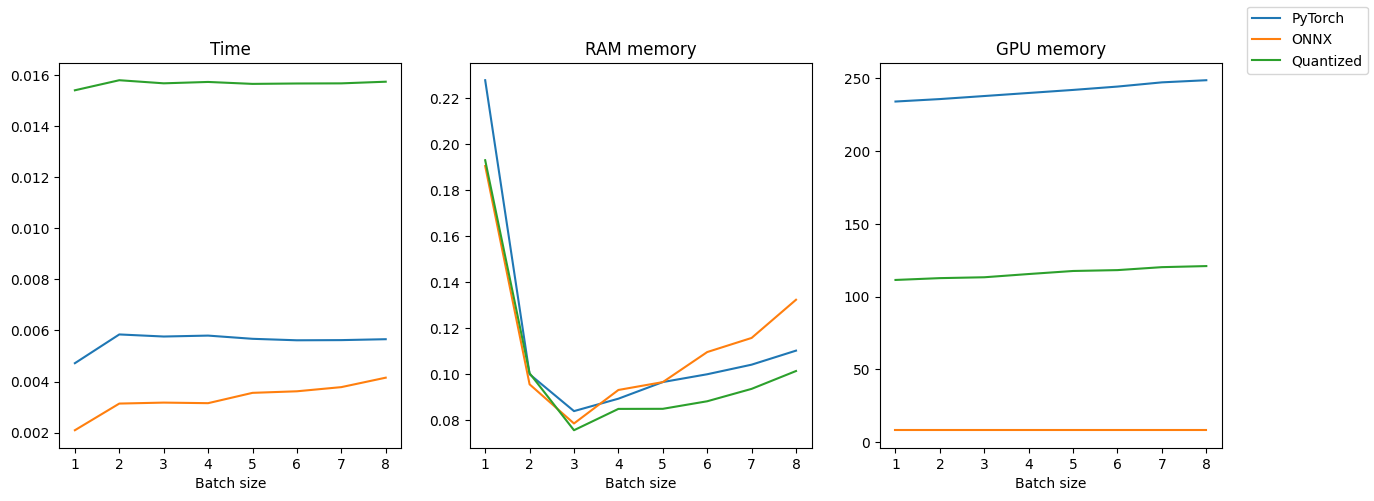

In [19]:
torch_quant_stats = get_stats(profile_torch, model_8bit, ner_tokenizer, device, True)
plot_stats([torch_stats, onnx_stats, torch_quant_stats], ['PyTorch', 'ONNX', 'Quantized'])

Квантизация замедляет инференс модели, так как добавленные в модель операции по приведению к нужному типу и обратно для исполнения квантизованных операций занимают больше времени, чем выигрыш, который даёт исполнение операций в меньшей разрядности.